In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
# read csv
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

# get feature data
X_train = train.drop(columns=['label']).transpose()

# get target variables
y_train = train['label']

# convert to numpy arrays
train = train.to_numpy()
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
test = test.to_numpy().transpose()

After recently completing Andrew Ng's course on Neural Networks and Deep Learning, I thought I'd implement what I've learned for this competition.

# Neural network from scratch.

The steps required to build and train a neural network are:

1. Define layer architecture
2. Initialise parameters
3. Forward propagation
4. Compute cost
5. Backward propagation
6. Update parameters

## 1. Define layer architecture

Let's find out how large our input layer must be from the number of pixels in an image.

In [3]:
X_train.shape[0]

784

In [4]:
layer_dims = [784, 20, 15, 10]

## 2. Initialise parameters

In [5]:
def initialise_parameters(layer_dims):
    
    # number of layers
    L = len(layer_dims)
    
    # initialise params dictionary
    parameters = dict()
    
    # cycle through layers and initialise parameters
    for l in range(1, L):
        parameters['W'+str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*0.01
        parameters['b'+str(l)] = np.zeros((layer_dims[l], 1))
    
    return parameters

parameters = initialise_parameters(layer_dims)

In [6]:
def linear_forward(A, W, b):
    
    Z = np.dot(W, A) + b

    cache = (A, W, b)
    return Z, cache

In [7]:
def ReLU(Z):
    
    relu = np.maximum(0, Z)
    
    return relu

In [8]:
def sigmoid(Z):
    
    sigmoid = np.divide(1, 1+np.exp(-Z))
    
    return sigmoid

In [9]:
# def softmax(Z):
    
#     softmax = np.exp(Z)/np.sum(np.sum(Z))
    
#     return softmax

def softmax(Z):
    expZ = np.exp(Z - np.max(Z))
    return expZ / expZ.sum(axis=0, keepdims=True)

In [10]:
def linear_activation_forward(A_prev, W, b, activation):
    
    # compute Z
    Z, linear_cache = linear_forward(A_prev, W, b)
        
    # compute A
    if activation == 'relu':
        A = ReLU(Z)
    elif activation == 'sigmoid':
        A = sigmoid(Z)
    elif activation == 'softmax':
        A = softmax(Z)
    
    # caches
    activation_cache = Z
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [11]:
# testing
parameters = initialise_parameters(layer_dims)
A, cache = linear_activation_forward(X_train, parameters['W1'], parameters['b1'], activation='softmax')

In [12]:
def l_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """
    
    # find number of layers
    L = len(parameters)//2
    
    # get ready to capture all caches from each layer
    caches = []
    
    # initialise A_prev as X
    A_prev = X
    
    # forward propagation for layers (aside from last)
    for l in range(1, L):
        
        # compute forward linear activation
        A, cache = linear_activation_forward(A_prev, parameters['W'+str(l)], parameters['b'+str(l)], activation='relu')

        # reset A_prev
        A_prev = A
        
        caches.append(cache)
    
    # forward propagation for last layer
    AL, cache = linear_activation_forward(A_prev, parameters['W'+str(L)], parameters['b'+str(L)], activation='softmax')
    caches.append(cache)
    
    return AL, caches

In [13]:
AL, caches = l_model_forward(X_train[:, [0]], parameters)
AL.shape

(10, 1)

In [14]:
def onehot_encoder(array):
    
    ohe = np.zeros((len(array), array.max()+1))
    ohe[np.arange(len(array)), array] = 1
    ohe = ohe.transpose()
    
    return ohe

In [15]:
def compute_cost(AL, y):
    
    # one hot encode y
    y_ohe = onehot_encoder(y)
    
    # number of examples
    m = len(y)
    
    # categorical cross-entropy loss function
    cost = (-1/m) * np.sum(y_ohe * np.log(AL))
    
    return cost

In [16]:
compute_cost(AL, y_train)

2.3027017219382215

In [17]:
def get_predictions(AL):
    predictions = np.argmax(AL, 0)
    return predictions

In [18]:
predictions = get_predictions(AL)
predictions

array([5])

In [19]:
def compute_accuracy(predictions, Y):
    
    accuracy = np.sum(predictions==Y)/Y.size
    
    return accuracy

In [20]:
def linear_backward(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dA_prev = np.dot(W.T, dZ)
    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    
    return dA_prev, dW, db

In [21]:
def linear_activation_backward(dA, cache, Y, activation_function):
    
    linear_cache, activation_cache = cache
    Z = activation_cache
    
    # calculation depends on activation function
    if activation_function=='sigmoid':
        
        dZ = dA * (sigmoid(Z)*(1-sigmoid(Z)))
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation_function=='softmax':
        
        dZ = softmax(Z) - Y
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation_function=='relu':
        
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

In [22]:
def l_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ... 
             grads["db" + str(l)] = ... 
    """
    
    # number of layers
    L = len(caches)
    
    # gradient storage
    grads = dict()    
    
    # one hot encode y
    Y_ohe = onehot_encoder(Y)
    
    # initiate backward propagation
#     print('Y:',Y_ohe)
#     print('AL:', AL)
    dAL = -np.divide(Y_ohe, AL) + np.divide(1-Y_ohe, 1-AL)
    
    # propagate backwards through last layer separately (as it has a different activation function)
    current_cache = caches[L-1]
#     print('layer:', L)
    grads['dA'+str(L-1)], grads['dW'+str(L)], grads['db'+str(L)] = linear_activation_backward(dAL, current_cache, Y_ohe, activation_function='softmax')
    
    # cycle through layers in reverse
    for l in reversed(range(1, L)):
        current_cache = caches[l-1]
#         print('layer:', l)
        grads['dA'+str(l-1)], grads['dW'+str(l)], grads['db'+str(l)] = linear_activation_backward(grads['dA'+str(l)], current_cache, Y_ohe, activation_function='relu')
        
    return grads

In [23]:
def update_parameters(params, grads, learning_rate):
    
    L = len(params)//2
        
    # cycle through each layer and change parameters
    for l in range(1, L+1):
        params['W'+str(l)] = params['W'+str(l)] - learning_rate * grads['dW'+str(l)]
        params['b'+str(l)] = params['b'+str(l)] - learning_rate * grads['db'+str(l)]
        
    return params

In [24]:
def l_layer_model(X, Y, layers_dim, learning_rate=0.001, num_iterations=100, print_cost=True):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    # initialise parameters
    params = initialise_parameters(layers_dim)
#     print('Initial W3:', params['W3'], params['W3'].shape)

    # repeat for number of iterations
    for i in range(0, num_iterations):

        # forward propagation
        AL, caches = l_model_forward(X, params)

        # compute cost - TRY REPLACING WITH PYTORTH EQUIVALENT
        cost = compute_cost(AL, Y)

        # backward propagation
        grads = l_model_backward(AL, Y, caches)
#         print(grads)
        
        # update parameters
        params = update_parameters(params, grads, learning_rate)
#         print(params)
                
        # get predictions
        predictions = get_predictions(AL)
        accuracy = compute_accuracy(predictions, Y)
        # print cost if required
        if print_cost==True and i%10==0:
            print('Iteration',i,'- cost:', cost)
            print('Accuracy:', accuracy)
    
    return params

In [25]:
model_params = l_layer_model(X_train, y_train, [784, 15, 10])

Iteration 0 - cost: 2.729793842588716
Accuracy: 0.10130952380952381
Iteration 10 - cost: 1.7608385498674421
Accuracy: 0.4613333333333333
Iteration 20 - cost: 1.2410026947715793
Accuracy: 0.6189761904761905
Iteration 30 - cost: 0.9624018381877896
Accuracy: 0.7011190476190476
Iteration 40 - cost: 0.8174791113380738
Accuracy: 0.7442857142857143
Iteration 50 - cost: 0.7252092907302768
Accuracy: 0.7732380952380953
Iteration 60 - cost: 0.657986722683986
Accuracy: 0.796
Iteration 70 - cost: 0.6059315725821766
Accuracy: 0.8133571428571429
Iteration 80 - cost: 0.5647108511524711
Accuracy: 0.8284285714285714
Iteration 90 - cost: 0.5361741584584978
Accuracy: 0.8372142857142857


In [26]:
def predict(X, parameters):
    
    # get scores after forward prop
    AL, _ = l_model_forward(X, parameters)
    
    # get predictions
    predictions = get_predictions(AL)
    
    return predictions

def test_prediction(index, parameters):
    
    # get prediction for example
    prediction = predict(X_train[:, [index]], parameters)
    
    # get label
    label = y_train[index]
    
    # show image
    plt.imshow(X_train[:, [index]].reshape(28, 28))
    print('Label:', label)
    print('Prediction:', prediction)
    

In [27]:
predict(X_train[:, [100]], model_params)

array([9])

Label: 1
Prediction: [1]


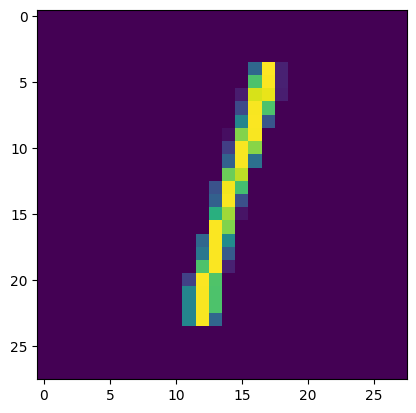

In [28]:
test_prediction(590, model_params)

# Hyperparameter tuning

In [29]:
np.random.seed(42)

# shuffle dataset
indices = np.arange(train.shape[0])
np.random.shuffle(indices)
train_shuffled = train[indices]

# validation ratio
validation_ratio = 0.2

# split index
split_index = int(train_shuffled.shape[0]*(1-validation_ratio))

# split data
train_split = train_shuffled[:split_index]
validation_split = train_shuffled[split_index:]

# split features and target variable
X_train = train_split[:,1:].transpose()
y_train = train_split[:,0].transpose()
X_val = validation_split[:,1:].transpose()
y_val = validation_split[:,0].transpose()

In [30]:
# hyperparameter space
parameter_grid = {
    'layer_dims':[
                [784, 15, 10], # small nn
                [784, 20, 15, 10], # medium nn
                [784, 50, 25, 15, 10] # large nn
    ], 
    'learning_rate':[0.01, 0.001],
    'num_iterations':[250, 100]
}

In [31]:
import itertools

keys, values = zip(*parameter_grid.items())
results = []
for parameter_combo in itertools.product(*values):
    
    # create parameter combination dictionary
    params = dict(zip(keys, parameter_combo))
    print(params)
    
    # train model
    model_params = l_layer_model(X_train, 
                                 y_train,
                                 layers_dim=params['layer_dims'],
                                 learning_rate=params['learning_rate'],
                                 num_iterations=params['num_iterations'],
                                 print_cost=True)
    
    
    # make predictions on the test set
    preds = predict(X_val, model_params)
    
    # get accuracy
    accuracy = compute_accuracy(preds, y_val)
    print(accuracy)
    
    # save results
    result = [params, model_params, accuracy]
    results.append(result)

{'layer_dims': [784, 15, 10], 'learning_rate': 0.01, 'num_iterations': 250}
Iteration 0 - cost: 2.520969922861924
Accuracy: 0.08273809523809524
Iteration 10 - cost: 2.2967025075529817
Accuracy: 0.11949404761904762
Iteration 20 - cost: 2.301952872765186
Accuracy: 0.1006547619047619
Iteration 30 - cost: 2.2102249839781956
Accuracy: 0.1805952380952381
Iteration 40 - cost: 2.084512917622927
Accuracy: 0.19508928571428572
Iteration 50 - cost: 2.2156452722688753
Accuracy: 0.19392857142857142
Iteration 60 - cost: 2.0755219268508878
Accuracy: 0.20294642857142858
Iteration 70 - cost: 2.0403550021849015
Accuracy: 0.20258928571428572
Iteration 80 - cost: 2.0494091134701717
Accuracy: 0.204375
Iteration 90 - cost: 2.0634971733423173
Accuracy: 0.20285714285714285
Iteration 100 - cost: 2.1120116483752205
Accuracy: 0.20636904761904762
Iteration 110 - cost: 2.2759323164641474
Accuracy: 0.10071428571428571
Iteration 120 - cost: 2.0344815396206033
Accuracy: 0.2069047619047619
Iteration 130 - cost: 2.06325

In [32]:
# find best accuracy
accuracies = [result[2] for result in results]
best_accuracy_index = np.argmax(accuracies)

# find best params
best_params = results[best_accuracy_index][1]

In [33]:
test_preds = predict(test, best_params)
test_preds

submission = pd.DataFrame(data=
                          {'ImageId':np.arange(1, test.shape[1]+1),
                          'Label':test_preds})

submission.to_csv('submission.csv', index=False)